In [ ]:
#Uso de librerías. Celda nº1
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings
from collections import defaultdict
from tabulate import tabulate
from google.colab import data_table
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#Preprocesamiento

In [ ]:
# Cargar el archivo Excel
xls = pd.ExcelFile("Test_animales.xlsx")
# Leer las hojas y asignar la nueva variable "degenera"
df_list = []
for i, sheet in enumerate(xls.sheet_names):
    df = xls.parse(sheet)
    df["degenera"] = i  # Asigna 0 a la primera hoja, 1 a la segunda, etc.
    df_list.append(df)

# Unir todas las hojas en un solo DataFrame
df = pd.concat(df_list, ignore_index=True)
# Guardar el resultado en un CSV
df.to_csv("Test_animales.csv", index=False)


data = pd.read_csv("Test_animales.csv", header =2)
# Asignar la primera fila como nombres de columnas
data.columns = data.iloc[0]  # Toma la primera fila como encabezados
data = data[1:].reset_index(drop=True)  # Eliminar la fila duplicada y resetear índice

# Asegurar que no hay nombres de columna repetidos
data.columns = [str(col) for col in data.columns]
display(data)

,Edad sacrificio,ID animal,Sexo,P30,3m,4m,6m,9m,12m,17-21m,...,OI,OD,OI,F.Optomotor,Edad Opto,Dato OPT,F.OCT,OD (400 um),OI,0
0,1,WT-25,♀,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,...,19.5,146.7,166.1,2020-02-17 00:00:00,"1,3m",0.572,2020-02-17 00:00:00,52.818,202.818,0
1,1,WT-110,♀,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1,WT-111,♂,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1,WT-112,♀,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1,WT-113,♂,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,P11,R10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
255,P11,R11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
256,P11,R12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
257,P11,R13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
# Contador para cada nombre de columna duplicada
oi_counter = 1
od_counter = 1
new_columns = []

# Renombrar correctamente las columnas duplicadas de OI y OD
for col in data.columns:
    if col.startswith("OI"):
        new_columns.append(f"OI_{oi_counter}")
        oi_counter += 1
    elif col.startswith("OD"):
        new_columns.append(f"OD_{od_counter}")
        od_counter += 1
    elif col.startswith("0"):
        new_columns.append("degenera")
    else:
        new_columns.append(col) # Mantener los demás nombres iguales
# Aplicar los nuevos nombres
data.columns = new_columns
# Mostrar el resultado
print(data.columns)


Index(['Edad sacrificio', 'ID animal', 'Sexo', 'P30', '3m', '4m', '6m', '9m',
       '12m', '17-21m', 'OD_1', 'OI_1', 'OD_2', 'OI_2', 'OD_3', 'OI_3', 'OD_4',
       'OI_4', 'F.Optomotor', 'Edad Opto', 'Dato OPT', 'F.OCT', 'OD_5', 'OI_5',
       'degenera'],
      dtype='object')


In [ ]:
# Contar las instancias de cada valor en "degenera"
conteo = data["degenera"].value_counts()
print(conteo)

degenera
0    131
1    128
Name: count, dtype: int64


In [ ]:
# Contar valores NaN en cada columna
nan_counts = data.isna().sum()
print(tabulate(nan_counts.reset_index(), headers=["Variable", "Cantidad de NaN"], tablefmt="pretty"))

+----+-----------------+-----------------+
|    |    Variable     | Cantidad de NaN |
+----+-----------------+-----------------+
| 0  | Edad sacrificio |        4        |
| 1  |    ID animal    |        1        |
| 2  |      Sexo       |       15        |
| 3  |       P30       |       246       |
| 4  |       3m        |       236       |
| 5  |       4m        |       252       |
| 6  |       6m        |       243       |
| 7  |       9m        |       243       |
| 8  |       12m       |       239       |
| 9  |     17-21m      |       241       |
| 10 |      OD_1       |       180       |
| 11 |      OI_1       |       184       |
| 12 |      OD_2       |       181       |
| 13 |      OI_2       |       184       |
| 14 |      OD_3       |       180       |
| 15 |      OI_3       |       184       |
| 16 |      OD_4       |       181       |
| 17 |      OI_4       |       184       |
| 18 |   F.Optomotor   |       160       |
| 19 |    Edad Opto    |       154       |
| 20 |    D

In [ ]:
# Seleccionar columnas que empiezan con "OI", "OD" o "Dato OPT"
oi_od_columns = [col for col in data.columns if col.startswith("OI") or col.startswith("OD") or col.startswith("Dato OPT")]
# Eliminar filas donde TODAS esas columnas sean NaN (si al menos una tiene valor, la fila se queda)
data = data.dropna(subset=oi_od_columns, how="all").reset_index(drop=True)
display(data)

,Edad sacrificio,ID animal,Sexo,P30,3m,4m,6m,9m,12m,17-21m,...,OI_3,OD_4,OI_4,F.Optomotor,Edad Opto,Dato OPT,F.OCT,OD_5,OI_5,degenera
0,1,WT-25,♀,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,...,19.5,146.7,166.1,2020-02-17 00:00:00,"1,3m",0.572,2020-02-17 00:00:00,52.818,202.818,0
1,1.3,WT-23,♀,110220-3,NaN,NaN,NaN,NaN,NaN,NaN,...,19.9,123.1,135.2,2020-02-17 00:00:00,"1,3m",0.574,2020-02-17 00:00:00,47.365,202.364,0
2,1.3,WT-24,♀,110220-4,NaN,NaN,NaN,NaN,NaN,NaN,...,19.3,184.3,183.7,2020-02-17 00:00:00,"1,3m",0.594,2020-02-17 00:00:00,54.94,209.455,0
3,1.3,WT-26,♂,110220-1,NaN,NaN,NaN,NaN,NaN,NaN,...,18.0,131.8,166.9,2020-02-17 00:00:00,"1,3m",0.550,2020-02-17 00:00:00,57.273,212.909,0
4,1.3,WT-27,♂,110220-2,NaN,NaN,NaN,NaN,NaN,NaN,...,16.5,181.2,142.6,2020-02-17 00:00:00,"1,3m",0.616,2020-02-17 00:00:00,51.091,202.545,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,19,12120,♀,NaN,NaN,NaN,NaN,NaN,NaN,110521-5,...,3,52,"84,8",NaN,NaN,"0,308",2021-04-28 00:00:00,NaN,NaN,1
103,20,12004,♀,NaN,NaN,NaN,NaN,NaN,NaN,190521-2,...,"3,2","63,1","57,1",NaN,NaN,"0,297",2021-04-26 00:00:00,NaN,NaN,1
104,20,12045,♂,NaN,NaN,NaN,NaN,NaN,NaN,190521-7,...,4,"93,2",85,NaN,NaN,"0,319",2021-04-27 00:00:00,NaN,NaN,1
105,20,12046,♂,NaN,NaN,NaN,NaN,NaN,NaN,190521-6,...,7,"52,5","91,7",NaN,NaN,"0,308",2021-04-27 00:00:00,NaN,NaN,1


In [ ]:
data.drop('Edad sacrificio',axis =1, inplace =True)
data.drop('F.Optomotor',axis =1, inplace =True)
data.drop('F.OCT',axis =1, inplace =True)
data.drop('ID animal',axis =1, inplace =True)
display(data)

,Sexo,P30,3m,4m,6m,9m,12m,17-21m,OD_1,OI_1,...,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera
0,♀,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,224.1,262.1,...,628.0,16.8,19.5,146.7,166.1,"1,3m",0.572,52.818,202.818,0
1,♀,110220-3,NaN,NaN,NaN,NaN,NaN,NaN,147.6,217.6,...,501.6,21.6,19.9,123.1,135.2,"1,3m",0.574,47.365,202.364,0
2,♀,110220-4,NaN,NaN,NaN,NaN,NaN,NaN,318.8,291.6,...,630.5,14.2,19.3,184.3,183.7,"1,3m",0.594,54.94,209.455,0
3,♂,110220-1,NaN,NaN,NaN,NaN,NaN,NaN,206.7,197.6,...,492.3,14.3,18.0,131.8,166.9,"1,3m",0.550,57.273,212.909,0
4,♂,110220-2,NaN,NaN,NaN,NaN,NaN,NaN,292.1,198.6,...,470.4,17.5,16.5,181.2,142.6,"1,3m",0.616,51.091,202.545,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,♀,NaN,NaN,NaN,NaN,NaN,NaN,110521-5,"78,1","72,1",...,"181,2",2,3,52,"84,8",NaN,"0,308",NaN,NaN,1
103,♀,NaN,NaN,NaN,NaN,NaN,NaN,190521-2,"65,1","60,8",...,"188,7",5,"3,2","63,1","57,1",NaN,"0,297",NaN,NaN,1
104,♂,NaN,NaN,NaN,NaN,NaN,NaN,190521-7,"92,2","83,8",...,"246,8",3,4,"93,2",85,NaN,"0,319",NaN,NaN,1
105,♂,NaN,NaN,NaN,NaN,NaN,NaN,190521-6,79,"113,1",...,"249,4",5,7,"52,5","91,7",NaN,"0,308",NaN,NaN,1


In [ ]:
data["Sexo"] = data["Sexo"].map({"♀": 0, "♂": 1})
data["Sexo"] = data["Sexo"].fillna(-1).astype(int)
print(data["Sexo"].value_counts())
display(data)

Sexo
 1    56
 0    44
-1     7
Name: count, dtype: int64


,Sexo,P30,3m,4m,6m,9m,12m,17-21m,OD_1,OI_1,...,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera
0,0,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,224.1,262.1,...,628.0,16.8,19.5,146.7,166.1,"1,3m",0.572,52.818,202.818,0
1,0,110220-3,NaN,NaN,NaN,NaN,NaN,NaN,147.6,217.6,...,501.6,21.6,19.9,123.1,135.2,"1,3m",0.574,47.365,202.364,0
2,0,110220-4,NaN,NaN,NaN,NaN,NaN,NaN,318.8,291.6,...,630.5,14.2,19.3,184.3,183.7,"1,3m",0.594,54.94,209.455,0
3,1,110220-1,NaN,NaN,NaN,NaN,NaN,NaN,206.7,197.6,...,492.3,14.3,18.0,131.8,166.9,"1,3m",0.550,57.273,212.909,0
4,1,110220-2,NaN,NaN,NaN,NaN,NaN,NaN,292.1,198.6,...,470.4,17.5,16.5,181.2,142.6,"1,3m",0.616,51.091,202.545,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0,NaN,NaN,NaN,NaN,NaN,NaN,110521-5,"78,1","72,1",...,"181,2",2,3,52,"84,8",NaN,"0,308",NaN,NaN,1
103,0,NaN,NaN,NaN,NaN,NaN,NaN,190521-2,"65,1","60,8",...,"188,7",5,"3,2","63,1","57,1",NaN,"0,297",NaN,NaN,1
104,1,NaN,NaN,NaN,NaN,NaN,NaN,190521-7,"92,2","83,8",...,"246,8",3,4,"93,2",85,NaN,"0,319",NaN,NaN,1
105,1,NaN,NaN,NaN,NaN,NaN,NaN,190521-6,79,"113,1",...,"249,4",5,7,"52,5","91,7",NaN,"0,308",NaN,NaN,1


In [ ]:
data["Edad_ERG"] = np.nan
edad_map = {
    "P30": 1,
    "3m": 3,
    "4m": 4,
    "6m": 6,
    "9m": 9,
    "12m": 12,
    "17-21m": 19
}

for col, val in edad_map.items():
    data.loc[data[col].notna(), "Edad_ERG"] = val

# Normalizar con Min-Max Scaling
min_val = min(edad_map.values())  # Mínimo (1)
max_val = max(edad_map.values())  # Máximo (19)
data["Edad_ERG"] = (data["Edad_ERG"] - min_val) / (max_val - min_val)
# Crear diccionario con valores normalizados
edad_normalizada = {
    nombre: round((valor - min_val) / (max_val - min_val), 3)
    for nombre, valor in edad_map.items()
}

# Mostrar
for nombre, valor_norm in edad_normalizada.items():
    print(f"{nombre}: {valor_norm}")

display(data[["P30", "3m", "4m", "6m", "9m", "12m", "17-21m", "Edad_ERG"]])

P30: 0.0
3m: 0.111
4m: 0.167
6m: 0.278
9m: 0.444
12m: 0.611
17-21m: 1.0


,P30,3m,4m,6m,9m,12m,17-21m,Edad_ERG
0,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,110220-3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,110220-4,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,110220-1,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,110220-2,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
102,NaN,NaN,NaN,NaN,NaN,NaN,110521-5,1.0
103,NaN,NaN,NaN,NaN,NaN,NaN,190521-2,1.0
104,NaN,NaN,NaN,NaN,NaN,NaN,190521-7,1.0
105,NaN,NaN,NaN,NaN,NaN,NaN,190521-6,1.0


In [ ]:
data = data.drop(columns=["P30", "3m", "4m", "6m", "9m", "12m", "17-21m"])
display(data)

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera,Edad_ERG
0,0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,"1,3m",0.572,52.818,202.818,0,0.0
1,0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,"1,3m",0.574,47.365,202.364,0,0.0
2,0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,"1,3m",0.594,54.94,209.455,0,0.0
3,1,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,"1,3m",0.550,57.273,212.909,0,0.0
4,1,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,"1,3m",0.616,51.091,202.545,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0,"78,1","72,1","174,8","181,2",2,3,52,"84,8",NaN,"0,308",NaN,NaN,1,1.0
103,0,"65,1","60,8","199,9","188,7",5,"3,2","63,1","57,1",NaN,"0,297",NaN,NaN,1,1.0
104,1,"92,2","83,8","264,3","246,8",3,4,"93,2",85,NaN,"0,319",NaN,NaN,1,1.0
105,1,79,"113,1","191,6","249,4",5,7,"52,5","91,7",NaN,"0,308",NaN,NaN,1,1.0


In [ ]:
data = data.drop_duplicates()
data = data.reset_index(drop=True)
display(data)

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera,Edad_ERG
0,0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,"1,3m",0.572,52.818,202.818,0,0.0
1,0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,"1,3m",0.574,47.365,202.364,0,0.0
2,0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,"1,3m",0.594,54.94,209.455,0,0.0
3,1,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,"1,3m",0.550,57.273,212.909,0,0.0
4,1,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,"1,3m",0.616,51.091,202.545,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0,"78,1","72,1","174,8","181,2",2,3,52,"84,8",NaN,"0,308",NaN,NaN,1,1.0
103,0,"65,1","60,8","199,9","188,7",5,"3,2","63,1","57,1",NaN,"0,297",NaN,NaN,1,1.0
104,1,"92,2","83,8","264,3","246,8",3,4,"93,2",85,NaN,"0,319",NaN,NaN,1,1.0
105,1,79,"113,1","191,6","249,4",5,7,"52,5","91,7",NaN,"0,308",NaN,NaN,1,1.0


In [ ]:
data = data.drop(index=[47,48, 49])
data = data.reset_index(drop=True)
data = data.replace({'\*': ''}, regex=True)
display(data)

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera,Edad_ERG
0,0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,"1,3m",0.572,52.818,202.818,0,0.0
1,0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,"1,3m",0.574,47.365,202.364,0,0.0
2,0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,"1,3m",0.594,54.94,209.455,0,0.0
3,1,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,"1,3m",0.550,57.273,212.909,0,0.0
4,1,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,"1,3m",0.616,51.091,202.545,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0,"78,1","72,1","174,8","181,2",2,3,52,"84,8",NaN,"0,308",NaN,NaN,1,1.0
100,0,"65,1","60,8","199,9","188,7",5,"3,2","63,1","57,1",NaN,"0,297",NaN,NaN,1,1.0
101,1,"92,2","83,8","264,3","246,8",3,4,"93,2",85,NaN,"0,319",NaN,NaN,1,1.0
102,1,79,"113,1","191,6","249,4",5,7,"52,5","91,7",NaN,"0,308",NaN,NaN,1,1.0


In [ ]:
# Contar las instancias de cada valor en "degenera"
conteo = data["degenera"].value_counts()
print(conteo)

degenera
1    57
0    47
Name: count, dtype: int64


In [ ]:
# Crear el segundo conjunto de datos eliminando variables innecesarias
data_modelo2 = data.drop(columns=["Edad Opto", "Dato OPT", "OD_5", "OI_5"])
display(data_modelo2)

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,degenera,Edad_ERG
0,0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,0,0.0
1,0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,0,0.0
2,0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,0,0.0
3,1,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,0,0.0
4,1,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99,0,"78,1","72,1","174,8","181,2",2,3,52,"84,8",1,1.0
100,0,"65,1","60,8","199,9","188,7",5,"3,2","63,1","57,1",1,1.0
101,1,"92,2","83,8","264,3","246,8",3,4,"93,2",85,1,1.0
102,1,79,"113,1","191,6","249,4",5,7,"52,5","91,7",1,1.0


In [ ]:
import numpy as np

# Lista de columnas a verificar
columnas_verificar = ["OD_1", "OI_1", "OD_2", "OI_2", "OD_3", "OI_3", "OD_4", "OI_4"]
data_modelo2.replace({',': '.'}, regex=True, inplace=True)
# Reemplazar "-" y "?" por NaN
data_modelo2.replace({"-": np.nan, "?": np.nan}, inplace=True)
# Eliminar filas donde TODAS estas columnas sean NaN
data_modelo2 = data_modelo2.dropna(subset=columnas_verificar, how='all')
data_modelo2.reset_index(drop=True, inplace=True)
display(data_modelo2)

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,degenera,Edad_ERG
0,0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,0,0.0
1,0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,0,0.0
2,0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,0,0.0
3,1,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,0,0.0
4,1,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
69,0,78.1,72.1,174.8,181.2,2,3,52,84.8,1,1.0
70,0,65.1,60.8,199.9,188.7,5,3.2,63.1,57.1,1,1.0
71,1,92.2,83.8,264.3,246.8,3,4,93.2,85,1,1.0
72,1,79,113.1,191.6,249.4,5,7,52.5,91.7,1,1.0


In [ ]:
# Reemplazar valores no numéricos y convertir a int
#data_modelo2 = data_modelo2.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
data_modelo2 = data_modelo2.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
# Verificar que todo es int
print(data_modelo2.dtypes)

Sexo        float64
OD_1        float64
OI_1        float64
OD_2        float64
OI_2        float64
OD_3        float64
OI_3        float64
OD_4        float64
OI_4        float64
degenera    float64
Edad_ERG    float64
dtype: object


In [ ]:
# Definir características (X) y variable objetivo (y)
X = data_modelo2.drop(columns=['degenera'])  # Eliminar la columna objetivo
y = data_modelo2['degenera']  # Variable objetivo
# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Escalar los datos (solo para modelos que lo necesitan)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
display (data_modelo2)

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,degenera,Edad_ERG
0,0.0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,0.0,0.0
1,0.0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,0.0,0.0
2,0.0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,0.0,0.0
3,1.0,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,0.0,0.0
4,1.0,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
69,0.0,78.1,72.1,174.8,181.2,2.0,3.0,52.0,84.8,1.0,1.0
70,0.0,65.1,60.8,199.9,188.7,5.0,3.2,63.1,57.1,1.0,1.0
71,1.0,92.2,83.8,264.3,246.8,3.0,4.0,93.2,85.0,1.0,1.0
72,1.0,79.0,113.1,191.6,249.4,5.0,7.0,52.5,91.7,1.0,1.0


# Parámetros de GridSearchCV

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Definir los parámetros a optimizar para SVM
param_grid_svm = {
    'C': [0.1, 1, 10],  # Parámetro de regularización
    'kernel': ['linear', 'rbf', 'poly'],  # Tipos de kernel
    'gamma': ['scale', 'auto']  # Parámetro de ajuste de la forma del kernel
}

# Usar GridSearchCV para encontrar los mejores parámetros
grid_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svm, cv=5)
grid_svm.fit(X_train_scaled, y_train)  # Usamos los datos escalados para SVM

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros para SVM:", grid_svm.best_params_)


Mejores parámetros para SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Definir los parámetros a optimizar para XGBoost
param_grid_xgb = {
    'n_estimators': [10, 20, 50, 100],  # Número de árboles
    'max_depth': [3, 4, 5, 6],  # Profundidad máxima de los árboles
    'learning_rate': [0.01, 0.1, 0.2]  # Tasa de aprendizaje
}

# Usar GridSearchCV para encontrar los mejores parámetros
grid_xgb = GridSearchCV(XGBClassifier(random_state=42), param_grid_xgb, cv=5)
grid_xgb.fit(X_train, y_train)  # Usamos los datos no escalados para XGBoost

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros para XGBoost:", grid_xgb.best_params_)


Mejores parámetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, None],
    'n_estimators': [10, 20, 50, 100]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Mejores parámetros:", grid.best_params_)

Mejores parámetros: {'max_depth': 5, 'n_estimators': 10}


In [ ]:
# Random Forest
rf = RandomForestClassifier(max_depth = 5, n_estimators = 10, random_state=42)
rf.fit(X_train, y_train)
# SVM
svm = SVC(C =1, gamma= 'scale', kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth = 4, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Modelo: Random Forest
Accuracy: 0.6000
Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        10
         1.0       0.40      0.40      0.40         5

    accuracy                           0.60        15
   macro avg       0.55      0.55      0.55        15
weighted avg       0.60      0.60      0.60        15

Matriz de Confusión para Random Forest:
 [[7 3]
 [3 2]]


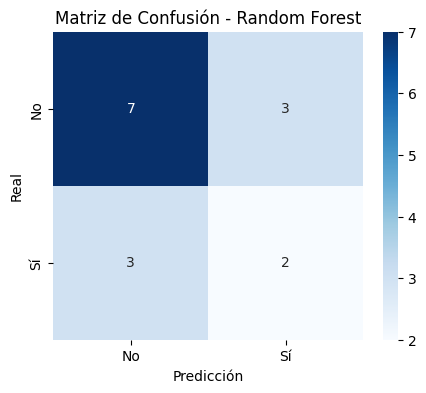

Modelo: SVM
Accuracy: 0.5333
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.60      0.63        10
         1.0       0.33      0.40      0.36         5

    accuracy                           0.53        15
   macro avg       0.50      0.50      0.50        15
weighted avg       0.56      0.53      0.54        15

Matriz de Confusión para SVM:
 [[6 4]
 [3 2]]


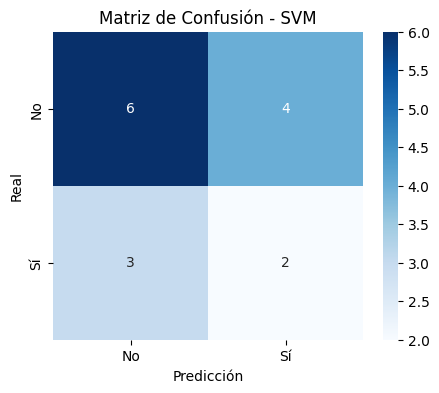

Modelo: XGBoost
Accuracy: 0.6000
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.60      0.67        10
         1.0       0.43      0.60      0.50         5

    accuracy                           0.60        15
   macro avg       0.59      0.60      0.58        15
weighted avg       0.64      0.60      0.61        15

Matriz de Confusión para XGBoost:
 [[6 4]
 [2 3]]


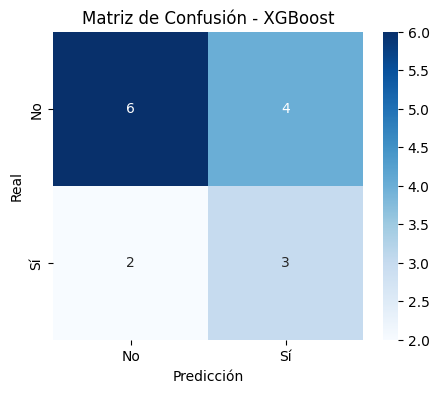

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluación de modelos ML
models = {'Random Forest': rf, 'SVM': svm, 'XGBoost': xgb}
for name, model in models.items():
    # Predicción de las clases
    y_pred = model.predict(X_test_scaled if name == 'SVM' else X_test)

    # Calcular y mostrar el accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Modelo: {name}")
    print(f"Accuracy: {accuracy:.4f}")

    # Imprimir el classification report
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

    # Calcular y mostrar la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print(f"Matriz de Confusión para {name}:\n", cm)

    # Graficar la matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {name}")
    plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# Rango de valores para búsqueda
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1.0, 1.5, 2.0],
}
xgb.fit(X_train, y_train)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:27:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Modelo: XGBoost
Accuracy: 0.5333
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.50      0.59        10
         1.0       0.38      0.60      0.46         5

    accuracy                           0.53        15
   macro avg       0.54      0.55      0.52        15
weighted avg       0.60      0.53      0.55        15

Matriz de Confusión para XGBoost:
 [[5 5]
 [2 3]]


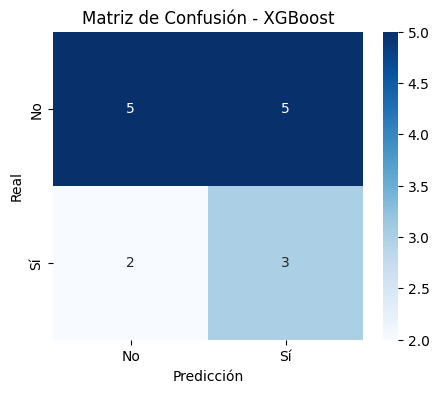

In [ ]:
# Evaluación solo para el modelo XGBoost
y_pred_xgb = xgb.predict(X_test)

# Calcular y mostrar el accuracy
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Modelo: XGBoost")
print(f"Accuracy: {accuracy:.4f}")

# Imprimir el classification report
print(f"Classification Report:\n{classification_report(y_test, y_pred_xgb)}")

# Calcular y mostrar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_xgb)
print(f"Matriz de Confusión para XGBoost:\n", cm)

# Graficar la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - XGBoost")
plt.show()

#Redes

In [ ]:
# Definir early stopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Modelo 1: Red Neuronal Densa (MLP)
model_mlp = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    # El dropout se usa para caso de overfitting para que la neurona no coja esa info o "no la vea" y no se ajuste el modelo tanto a los datos
    Dropout(0.2),
    # La activación de relu es por la estructura de clasificación y además en la operación en caso de que sea negativo de que el resultado sea negativo, los convierte a 0
    # Hablamos de la operación de activación
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
#Optimizadora Adam, hace uqe el peso de las neuronas se vaya modificando para disminuir el loss
#Optimizador con otro realmente no cambia mucho pero me decanto por el Adam que es el más usado
#Loss diferencia entre lo real y lo q ue el ha dicho
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Entrenar MLP
model_mlp.fit(X_train_scaled, y_train, epochs=50, batch_size=8, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

In [ ]:
# Definir early stopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Modelo 1: Red Neuronal Densa (MLP)
model_mlp = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    # El dropout se usa para caso de overfitting para que la neurona no coja esa info o "no la vea" y no se ajuste el modelo tanto a los datos
    Dropout(0.2),
    # La activación de relu es por la estructura de clasificación y además en la operación en caso de que sea negativo de que el resultado sea negativo, los convierte a 0
    # Hablamos de la operación de activación
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
#Optimizadora Adam, hace uqe el peso de las neuronas se vaya modificando para disminuir el loss
#Optimizador con otro realmente no cambia mucho pero me decanto por el Adam que es el más usado
#Loss diferencia entre lo real y lo q ue el ha dicho
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Entrenar MLP
model_mlp.fit(X_train_scaled, y_train, epochs=50, batch_size=8, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.5687 - loss: 0.6742 - val_accuracy: 0.4667 - val_loss: 0.7040
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4855 - loss: 0.6875 - val_accuracy: 0.4667 - val_loss: 0.7029
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4790 - loss: 0.6873 - val_accuracy: 0.4667 - val_loss: 0.7012
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5932 - loss: 0.6817 - val_accuracy: 0.4667 - val_loss: 0.7001
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6401 - loss: 0.6622 - val_accuracy: 0.4000 - val_loss: 0.7008
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4822 - loss: 0.6943 - val_accuracy: 0.4000 - val_loss: 0.6987
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5271 - loss: 0.6667 - val_accuracy: 0.4000 - val_loss: 0.6984
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5785 - loss: 0.6657 - val_accuracy: 0.4000 - val_loss: 0.6989

In [ ]:
# Modelo 2: Red Neuronal Profunda (DNN)
model_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar DNN
model_dnn.fit(X_train_scaled, y_train, epochs=100, batch_size=8, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5133 - loss: 0.7152 - val_accuracy: 0.6000 - val_loss: 0.6830
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5923 - loss: 0.6739 - val_accuracy: 0.4667 - val_loss: 0.6994
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5602 - loss: 0.6699 - val_accuracy: 0.3333 - val_loss: 0.7084
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7018 - loss: 0.6374 - val_accuracy: 0.3333 - val_loss: 0.7186
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7217 - loss: 0.6225 - val_accuracy: 0.4000 - val_loss: 0.7222
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6908 - loss: 0.6112 - val_accuracy: 0.4000 - val_loss: 0.7202
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6727 - loss: 0.6116 - val_accuracy: 0.4000 - val_loss: 0.7244
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7923 - loss: 0.5884 - val_accuracy: 0.3333 - val_loss: 0.7262
Epoc

In [ ]:
# Evaluación de modelos DL
mlp_loss, mlp_acc = model_mlp.evaluate(X_test_scaled, y_test)
dnn_loss, dnn_acc = model_dnn.evaluate(X_test_scaled, y_test)

print(f"MLP Accuracy: {mlp_acc:.4f}")
print(f"DNN Accuracy: {dnn_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4667 - loss: 0.6899
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6000 - loss: 0.6830
MLP Accuracy: 0.4667
DNN Accuracy: 0.6000
